In [28]:
file_path = '/data/zbw/inference_system/MIG_MPS/log/mobilenet_v2_MPS_QSP'

class ConfigData:
    def __init__(self, sm, batch, p99):
        self.sm = sm  # SM值
        self.batch = batch  # Batch值
        self.p99 = p99  # P99值

    def __repr__(self):
        return f"ConfigData(SM: {self.sm}, Batch: {self.batch}, P99: {self.p99})"

    

def parse_line(line):
    parts = line.strip().split(", ")
    print(parts)
    sm_batch = parts[0].split(" ")[1].split("+")
    sm = int(sm_batch[0])
    batch = int(sm_batch[1])
    p99 = float(parts[1].split(": ")[1])
    return ConfigData(sm, batch, p99)

def read_data_from_file(file_path):
    config_list = []
    with open(file_path, 'r') as file:
        for line in file:
            config = parse_line(line)
            config_list.append(config)
    return config_list

def find_max_batch_under_p99(config_list, sm_value, p99_threshold):
    max_batch = None
    for config in config_list:
        # print(config)
        # print(config.batch)
        if config.sm == sm_value and config.p99 <= p99_threshold:
            if max_batch is None or config.batch > max_batch.batch:
                max_batch = config
    return max_batch.batch

config_list = read_data_from_file(file_path)
SM_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
QPS_list = []
for i in SM_list:
    if i == 100:
        QPS = find_max_batch_under_p99(config_list, i, 50)
        print(i, QPS)
        QPS_list.append(QPS)
    else:
        QPS = find_max_batch_under_p99(config_list, i, 50)
        print(i, QPS)
        QPS_list.append(QPS)




['Config: 100+10', 'P99: 5.21693229675293']
['Config: 100+11', 'P99: 4.483091831207275']
['Config: 100+12', 'P99: 4.897618293762207']
['Config: 100+13', 'P99: 5.87313175201416']
['Config: 100+14', 'P99: 5.7098388671875']
['Config: 100+15', 'P99: 6.218194961547852']
['Config: 100+16', 'P99: 6.215715408325195']
['Config: 100+17', 'P99: 6.822621822357178']
['Config: 100+18', 'P99: 7.050943374633789']
['Config: 100+19', 'P99: 7.765448093414307']
['Config: 100+20', 'P99: 7.899999618530273']
['Config: 100+21', 'P99: 8.477497100830078']
['Config: 100+22', 'P99: 8.840477466583252']
['Config: 100+23', 'P99: 9.00259017944336']
['Config: 100+24', 'P99: 10.888421535491943']
['Config: 100+25', 'P99: 9.904468059539795']
['Config: 100+26', 'P99: 10.632431507110596']
['Config: 100+27', 'P99: 11.111819744110107']
['Config: 100+28', 'P99: 10.553944110870361']
['Config: 100+29', 'P99: 11.959397792816162']
['Config: 100+30', 'P99: 12.042045593261719']
['Config: 100+31', 'P99: 12.729942798614502']
['Config

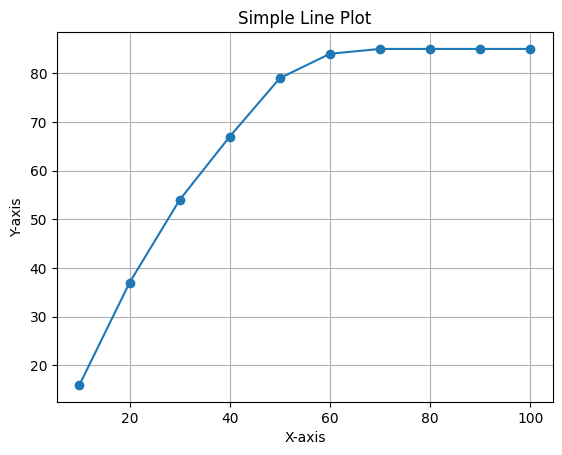

In [31]:
import matplotlib.pyplot as plt

x = SM_list
y=QPS_list
# y = []
# for i in QPS_list:
#     print(i)
#     y.append(i.batch)
plt.plot(x, y, marker='o')  # 使用'o'标记点

# 添加标题和标签
plt.title("Simple Line Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.grid(True)

# 显示图表
plt.show()


In [30]:
file_path = '/data/zbw/inference_system/MIG_MPS/log/pairs_MPS_QPS'
def parse_line(line):
    parts = line.strip().split(", ")
    config = parts[0].split(": ")[1]
    p99 = float(parts[1].split(": ")[1])
    return {"config": config, "p99": p99}

def read_data_from_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(parse_line(line))
    return data

def find_max_batch_sum(data, p99_threshold):
    max_batch_sum = 0
    max_batch_config = None

    # 遍历数据，每两行为一组
    for i in range(0, len(data), 2):
        group = data[i:i+2]
        
        # 检查两行数据的P99值是否都不超过阈值
        if all(entry["p99"] <= p99_threshold for entry in group):
            # 计算两行的batch值
            batch_sum = sum(int(entry["config"].split("+")[1]) for entry in group)
            
            # 更新最大batch值
            if batch_sum > max_batch_sum:
                max_batch_sum = batch_sum
                max_batch_config = group

    return max_batch_sum, max_batch_config


data = read_data_from_file(file_path)

# 设置P99的阈值
p99_threshold = 50

max_batch_sum, max_batch_config = find_max_batch_sum(data, p99_threshold)

# 输出结果
if max_batch_config:
    print(f"最大合法batch值之和: {max_batch_sum}")
    for entry in max_batch_config:
        print(f"Config: {entry['config']}, P99: {entry['p99']}")
else:
    print("没有找到合法的batch组合")


最大合法batch值之和: 64
Config: 50+31, P99: 48.84672164916992
Config: 50+33, P99: 49.71582889556885
